<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.b.isolation-forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.utils import shuffle



# I prepared these libraries for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from andrea_models import subsample
from visualization import silhouette_diagram

--2020-04-03 06:48:56--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py’

andrea_models.py    100%[===================>]   3.12K  --.-KB/s    in 0s      

2020-04-03 06:48:56 (58.4 MB/s) - ‘andrea_models.py’ saved [3190/3190]

--2020-04-03 06:48:59--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request s

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The following code is the same as in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb).

In [2]:
np.random.seed(9)
random.seed(9)

! wget https://datahub.io/machine-learning/creditcard/r/creditcard.csv

df = pd.read_csv('creditcard.csv')
df.head()

df.info(verbose=True)
df['Class'].value_counts()
num_of_normal = sum( df['Class']=="'0'" )
num_of_anomalies = sum( df['Class']=="'1'" )
num_of_anomalies/num_of_normal

df = df.drop('Time', axis=1)
X = df.drop('Class', axis=1)
y = [1 if c=="'1'" else 0 for c in df['Class']] 

--2020-04-03 06:49:04--  https://datahub.io/machine-learning/creditcard/r/creditcard.csv
Resolving datahub.io (datahub.io)... 104.18.49.253, 104.18.48.253, 2606:4700:3033::6812:31fd, ...
Connecting to datahub.io (datahub.io)|104.18.49.253|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv [following]
--2020-04-03 06:49:06--  https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 104.18.48.253, 104.18.49.253, 2606:4700:3033::6812:31fd, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|104.18.48.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151114991 (144M) [text/csv]
Saving to: ‘creditcard.csv’

creditcard.csv      100%[===================>] 144.11M  9.30MB/s    in 1

Differently than KMeans, isolation forests do not need any scaling.

# Anomaly detection

We will apply isolation forests on the credit card fraud dataset, already used in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb). A similar notebook can be found in [Kaggle](https://www.kaggle.com/amarnayak/testing-isolation-forest-for-fraud-detection). 

 As in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb), we separate training and test set.

In [0]:
X, y = shuffle(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
model = IsolationForest()

Our approach is unsupervised, so we **don't use y into fit(..)**

In [0]:
model.fit(X_train)
anomaly_scores = - model.decision_function(X_train)

Text(0.5, 0, 'Recall')

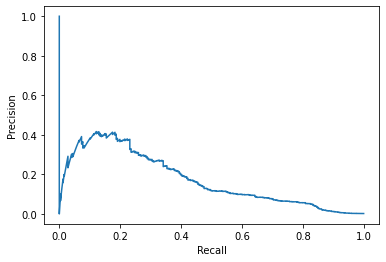

In [5]:
precision, recall, thresholds = precision_recall_curve(y_train, anomaly_scores)
plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')

Our isolation tree is still bad. We expect a very small Area Under the Curve (AUC).

In [6]:
auc_score = average_precision_score(y_train,anomaly_scores)
auc_score

0.1733991913360156

Create a function to put all these evaluations together

In [0]:
def evaluate_anomaly_detector(y_train, anomaly_scores):
  precision, recall, thresholds = precision_recall_curve(y_train, anomaly_scores)
  plt.plot(recall, precision)
  plt.ylabel('Precision')
  plt.xlabel('Recall')

  auc_score = average_precision_score(y_train,anomaly_scores)
  print("Area under the precision-recall curve:", auc_score)

  return precision, recall, thresholds, auc_score

# Hyper-paramter tuning


### Number of trees

Increasing the number of trees always improves performance

In [8]:
model = IsolationForest(n_estimators=500)
model.fit(X_train)


IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=500,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

Area under the precision-recall curve: 0.16061742847406832


(array([0.00201562, 0.00200744, 0.00200746, ..., 0.        , 0.        ,
        1.        ]),
 array([1.        , 0.99593496, 0.99593496, ..., 0.        , 0.        ,
        0.        ]),
 array([-0.13603157, -0.13603122, -0.13603109, ...,  0.25744372,
         0.25888364,  0.27462814]),
 0.16061742847406832)

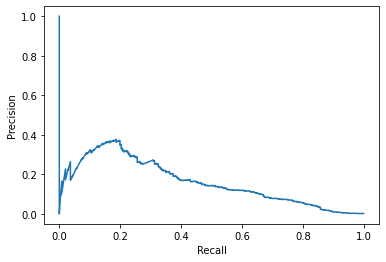

In [9]:
anomaly_scores = -model.decision_function(X_train)
evaluate_anomaly_detector(y_train, anomaly_scores)

### Others

GridSearch from `sklearn` is not simple (however not impossible) to apply. It is more simple to make a grid search manually

In [10]:
iforest = IsolationForest(n_estimators=500)

for max_features in [1, 15, 29]]:
  for max_samples in range(256, X_train.shape[0], int(X_train.shape[0] / 3) ):
    model = IsolationForest(n_estimators=500, max_features=max_features,
                            max_samples = max_samples)
    model.fit(X_train)
    anomaly_scores = -model.decision_function(X_train)
    auc_score = average_precision_score(y_train, anomaly_scores)
    print("max_fetaures:", max_features, "; max_samples:", max_samples, 
          "auc_score:", auc_score)

max_fetaures: 1 ; max_samples: 256 auc_score: 0.1554807662884762
max_fetaures: 1 ; max_samples: 47723 auc_score: 0.20355469917939423
max_fetaures: 1 ; max_samples: 95190 auc_score: 0.1956571483808927
max_fetaures: 8 ; max_samples: 256 auc_score: 0.15031115242271875
max_fetaures: 8 ; max_samples: 47723 auc_score: 0.21816838445008577
max_fetaures: 8 ; max_samples: 95190 auc_score: 0.22253782689201337
max_fetaures: 15 ; max_samples: 256 auc_score: 0.15045454246695456
max_fetaures: 15 ; max_samples: 47723 auc_score: 0.21652447392159815
max_fetaures: 15 ; max_samples: 95190 auc_score: 0.22484062834095425


Let's evaluate the best configuration we found

Area under the precision-recall curve: 0.23135663789230024


(array([0.00206148, 0.00205311, 0.00205313, ..., 0.        , 0.        ,
        1.        ]),
 array([1.        , 0.99593496, 0.99593496, ..., 0.        , 0.        ,
        0.        ]),
 array([-0.17576869, -0.17576855, -0.17576811, ...,  0.31796645,
         0.32023937,  0.36276485]),
 0.23135663789230024)

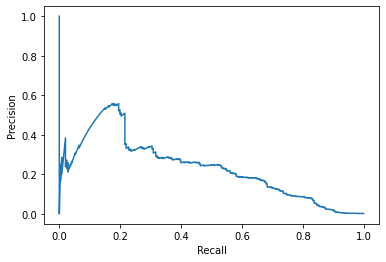

In [11]:
n_estimators=500
max_features = 29
max_samples = 47723

model = IsolationForest(n_estimators=n_estimators, max_features=max_features,
                        max_samples=max_samples)

model.fit(X_train)
anomaly_scores = -model.decision_.function(X_train)
evaluate_anomaly_detector(y_train, anomaly_scores)

Note that `auc_score` is different, since isolation forests have a lot of randomness.

No real improvement. Try to increase the number of trees.

Area under the precision-recall curve: 0.22610781937429875


(array([0.00203329, 0.00202504, 0.00202506, ..., 0.        , 0.        ,
        1.        ]),
 array([1.        , 0.99593496, 0.99593496, ..., 0.        , 0.        ,
        0.        ]),
 array([-0.17917069, -0.17917057, -0.17917052, ...,  0.31785516,
         0.31916658,  0.35917984]),
 0.22610781937429875)

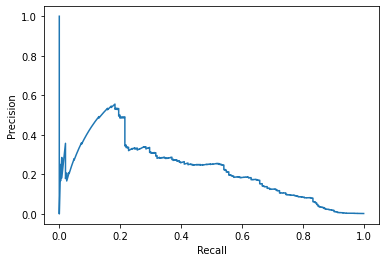

In [13]:
n_estimators = 1500

model = IsolationForest(n_estimators=n_estimators, max_features=max_features,
                        max_samples=max_samples)

model.fit(X_train)
anomaly_scores = -model.decision_function(X_train)
evaluate_anomaly_detector(y_train, anomaly_scores)

# ROC curve

Add to our evaluation function the code to plot the ROC curve

In [0]:
def plot_precision_recall_curve(y_train, anomaly_scores, ax1):
  """
  Inspired by 
    http://abhay.harpale.net/blog/machine-learning/threshold-tuning-using-roc/
  """
  
  precision, recall, thresholds = precision_recall_curve(y_train, anomaly_scores)
  pr_auc_score = average_precision_score(y_train,anomaly_scores)

  ax1.plot(recall, precision, 
           label='Pr-Re curve (AUC = %0.2f)' % (pr_auc_score))
  ax1.set_ylabel('Precision')
  ax1.set_xlabel('Recall')

  ax1_tw = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  ax1_tw.plot(recall[:-1], thresholds,linestyle='dashed', color='r', 
              label='Threshold')
  ax1_tw.tick_params(axis='y')
  ax1_tw.set_ylabel('Threshold')
  ax1.grid(True)
  ax1.legend(loc="lower center")
  ax1.set_xticks(np.arange(0, 1+0.09, 0.1))
  ax1.set_yticks(np.arange(0, 1+0.09, 0.1))
  return ax1


def plot_roc_curve(y_train, anomaly_scores, ax2):
  """
  Inspired by 
    http://abhay.harpale.net/blog/machine-learning/threshold-tuning-using-roc/
  """
  
  fpr, tpr, thresholds_roc = roc_curve(y_train, anomaly_scores)
  roc_auc_sc = roc_auc_score(y_train, anomaly_scores)
  # The thresholds obtained here are the same as the ones obtained with the
  # precision-recall curve
  
  ax2.plot(fpr, tpr, label='ROC (AUC = %0.2f)' % (roc_auc_sc))
  ax2.set_ylabel('True Positive Rate: TP/(TP+FN) )')
  ax2.set_xlabel('False Positive Rate: FP/(FP+TN)')

  # Also plot the thresholds
  ax2_tw = ax2.twinx()  # instantiate a second axes that shares the same x-axis
  ax2_tw.plot(recall[:-1], thresholds,linestyle='dashed', color='r', 
              label='Threshold')
  ax2_tw.tick_params(axis='y')
  ax2_tw.set_ylabel('Threshold')
  ax2.grid(True)
  ax2.legend(loc="lower center")
  ax2.set_xticks(np.arange(0, 1+0.09, 0.1))
  ax2.set_yticks(np.arange(0, 1+0.09, 0.1))
  return ax2






def evaluate_anomaly_detector(y_train, anomaly_scores):
  """
    Fig.3.4 of Geron, Hands-On Machine Learning with Scikit-Learn, Keras, and 
            TensorFlow, O'Reilly 2019
  """
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 7))

  plot_precision_recall_curve(y_train, anomaly_scores, ax1)
  plot_roc_curve(y_train, anomaly_scores, ax2)  

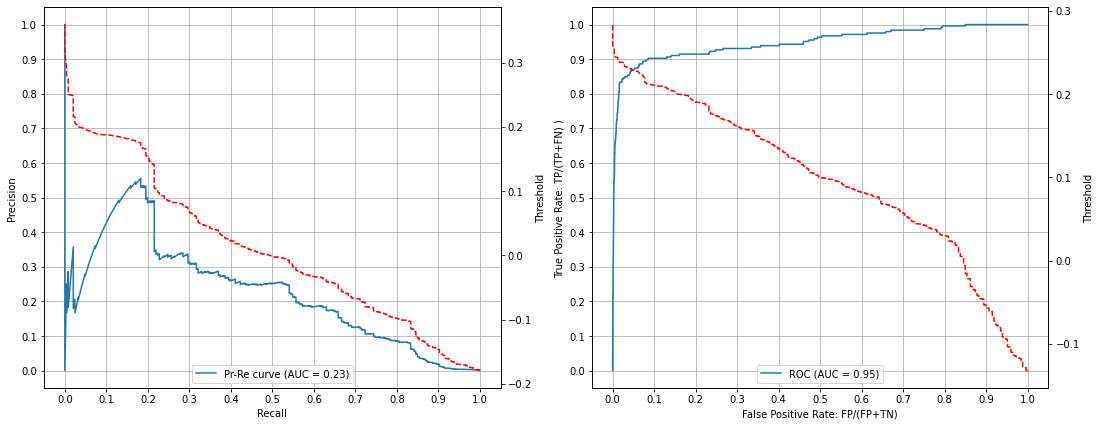

In [86]:
evaluate_anomaly_detector(y_train, anomaly_scores)

Observe that:
* Precision and recall is "merciless". This is because it is very difficult to be "precise"
* If we wanto to find 80% of anomalies, the alarms are true 10% of the times
* 10% of normal activities will raise false alarms

# Todo

Check:
* https://medium.com/datadriveninvestor/credit-card-fraud-detection-using-local-outlier-factor-and-isolation-forest-in-python-56edd0a44af5
* https://medium.com/learningdatascience/anomaly-detection-techniques-in-python-50f650c75aaf